<a href="https://colab.research.google.com/github/spdkh/Unrolled-optimization-with-deep-priors/blob/master/CIRL_ODPipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# SOURCE: https://github.com/Zhengqi-Wu/Unrolled-optimization-with-deep-priors
from scipy.io import loadmat
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import glob

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from PIL import Image

row = 180
col = 180
samples = 200
# data1 = np.zeros([samples, row, col, 1], dtype=np.uint8)
blurred = []
sharp = []
kernel = []

# print(data[0])
path = '/content/drive/MyDrive/data/'
folder = '/blurred/'



def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


j = 0

names = ['groundtruth', 'kernel', 'blurred']
for i in range(0, samples * 4, 4):
        
    number = '_000_0' + str(i // 4) if i < 4 else \
    '_' + '0' * (2 - int(np.log10(i // 4))) + str(i // 4) + '_0' + str(i % 4)
    if i % (samples // 5) == 0:
        print(i, number)
        
    im_path = path + 'sharp/' + names[0] + number + '.png'
    img = mpimg.imread(im_path)
    img = cv2.resize(img, dsize=(row, col))
    sharp.append(img.reshape(row, col, 3))

    im_path = path + 'kernel/' + names[1] + number + '.png'
    img = mpimg.imread(im_path)
    kernel.append(img)
    
    im_path = path + 'blurred/' + names[2] + number + '.png'
    img = mpimg.imread(im_path)
    img = cv2.resize(img, dsize=(row, col))
    blurred.append(img.reshape(row, col, 3))


print(len(sharp), len(blurred), len(kernel))
blurred = np.array(blurred)
sharp = np.array(sharp)
kernel = np.array(kernel)
print(sharp.shape, kernel.shape, blurred.shape)

0 _000_00
40 _010_00
80 _020_00
120 _030_00
160 _040_00
200 _050_00
240 _060_00
280 _070_00
320 _080_00
360 _090_00
400 _100_00
440 _110_00
480 _120_00
520 _130_00
560 _140_00
600 _150_00
640 _160_00
680 _170_00
720 _180_00
760 _190_00
200 200 200
(200, 180, 180, 3) (200, 31, 31) (200, 180, 180, 3)


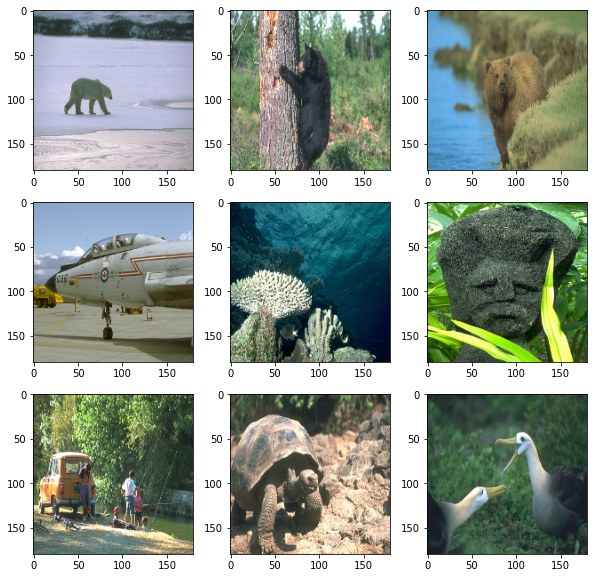

In [3]:
# Source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Lecture_8.ipynb
# The data, split between train and test sets:
# plot first few images
# define subplot
axes = plt.figure(figsize=(10,10)).subplots(3, 3)

for i, ax in enumerate(axes.ravel()):
	ax.imshow(sharp[i])

plt.show()


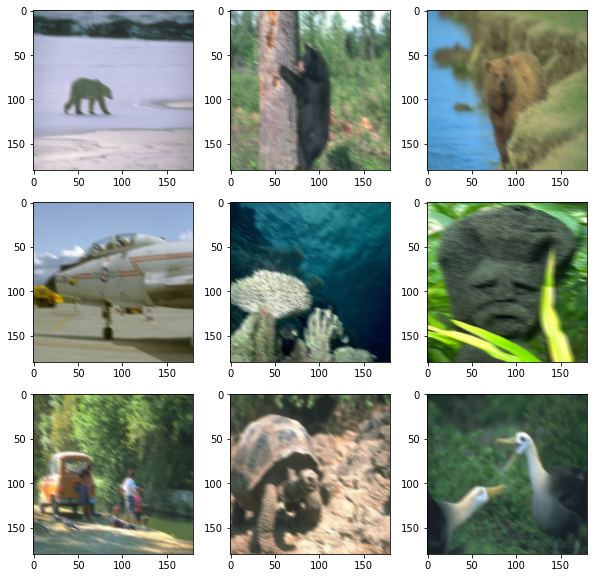

In [4]:
# Source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Lecture_8.ipynb
# The data, split between train and test sets:
# plot first few images
# define subplot
axes = plt.figure(figsize=(10,10)).subplots(3, 3)

for i, ax in enumerate(axes.ravel()):
	ax.imshow(blurred[i])

plt.show()


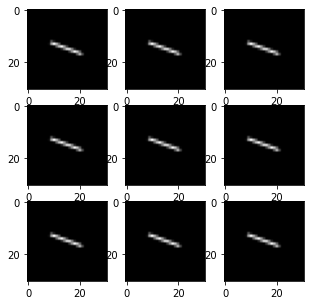

In [5]:

# Source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Lecture_8.ipynb
# The data, split between train and test sets:
# plot first few images
# define subplot
axes = plt.figure(figsize=(5,5)).subplots(3, 3)

for i, ax in enumerate(axes.ravel()):
	ax.imshow(kernel[i], cmap='gray')

plt.show()


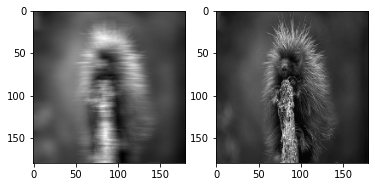

In [ ]:
import cv2

size = 15

# generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

for i in range(samples):
  data[0, i] = cv2.filter2D(data[2, i], -1, kernel_motion_blur).reshape(row,col,1)

plot_beside([data[0, 0,:,:,0], data[2, 0,:,:,0]], 2)
plt.show()

In [6]:

skip = 1
ratio = 0.75
slc = int(ratio * sharp.shape[0])
x_train = blurred[:slc:skip]
k_train = kernel[:slc:skip]
y_train = sharp[:slc:skip]

x_test = blurred[slc::skip]
k_test = kernel[slc::skip]
y_test = sharp[slc::skip]

x_train = x_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
y_train2 = y_train - x_train + 0.5
x_test = x_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
y_test2 = y_test - x_test + 0.5
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(150, 180, 180, 3) (150, 180, 180, 3) (50, 180, 180, 3) (50, 180, 180, 3)


In [7]:
kernel = kernel.astype('float32')
print(k_train.shape, k_test.shape)

(150, 31, 31) (50, 31, 31)


In [ ]:
k = kernel_motion_blur
kT = tf.Variable(k.transpose())
#kT = tf.cast(kT, dtype=tf.float32)
k = tf.Variable(k)
k = tf.cast(k, dtype=tf.complex64)
K = tf.signal.fft2d(k) 
Ki = np.linalg.pinv(K)
Ki = np.float32(Ki)
Ki

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [12]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [43]:
tf.executing_eagerly()

True

In [11]:
layer1 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer2 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer3 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer4 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer5 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer6 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer7 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer8 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer9 = layers.Conv2D(64, 3, activation='relu', padding='same')
layer10 = layers.Conv2D(1, 3, activation='relu', padding='same')

# define iterations and learning rate of ODP
#define iterations and learning rate of ODP

it = 5 # number of iterations
alpha = 0.01

#define layers of CNN
#weights = tf.get_variable(name='weights', shape=[5, 5, 3, 16], dtype=tf.float32)
input_img = layers.Input(shape=(row, col, 3)) 
y = input_img

x = input_img
tf.executing_eagerly()
for i in range(it):
  #if i == 0:
    #x = input_img
  #else:
    #x = output
  x_shortcut = x # save for residual process

  # Deep Network
  x = layer1(x)
  x = layer2(x) 
  x = layer3(x) 
  x = layer4(x) 
  x = layer5(x) 
  x = layer6(x) 
  x = layer7(x) 
  x = layer8(x) 
  x = layer9(x) 
  x = layer10(x)

  ## Add x
  x = tf.add(x_shortcut, x)

  # Add y.k^T.alpha 
#   x = tf.add(A, x) # reduce x by 0.5. Otherwise x in previous step would be negative.
#   y_arr = y.eval(session=tf.compat.v1.Session())
#   ya = cv2.filter2D(y, -1, k_T).reshape(row,col,1)

  ya = tf.nn.conv2d(y, k_T, strides=[1, 1, 1, 1], padding='SAME')
#   ya = tf.
#   for i in range(samples):
#     data[0, i] = cv2.filter2D(data[2, i], -1, kernel_motion_blur).reshape(row,col,1)
  ya = tf.multiply(y, alpha)
  x = tf.add(x, ya)
  x = tf.multiply(x, 1/(1+alpha))
  alpha = alpha/2

output = x

ODP = models.Model(input_img, output)
ODP.compile(optimizer=Adam(learning_rate=0.001),
            loss='mean_squared_error',
            metrics = ['accuracy'])
print(ODP.summary())
print(np.shape(output), x_train.shape, y_test.shape)

history = ODP.fit(x_train, y_train,
        epochs=10,
        batch_size=20,
        shuffle=True,
        validation_data=(x_test, y_test),
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

# 20 epoch 2 it resnet
y_pred = ODP.predict(x_test, batch_size=20)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 180, 180, 64  1792        ['input_2[0][0]',                
                                )                                 'tf.math.multiply_1[0][0]',     
                                                                  'tf.math.multiply_3[0][0]',     
                                                                  'tf.math.multiply_5[0][0]',     
                                                                  'tf.math.multiply_7[0][0]'] 

In [63]:
x_in.shape

(1, 5, 5, 1)

In [66]:
k_rgb.shape

(2, 2, 3, 1)

In [9]:

k = np.expand_dims(kernel[0].T, axis=2) # input channels dim
k = np.expand_dims(k, axis=3) # output channels dim
k = np.repeat(k, 3, axis=2) # duplicate along the input channels dim
k_T = tf.constant(k, dtype=tf.float32)
# tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID')

In [49]:
kernel[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
      

In [ ]:
def plot_beside(imgs, w):
    axs = plt.figure(figsize=(30,10)).subplots(1, w)
    i = 0
    for ax in axs:
        ax.imshow(imgs[i])
        i += 1

    plt.show()

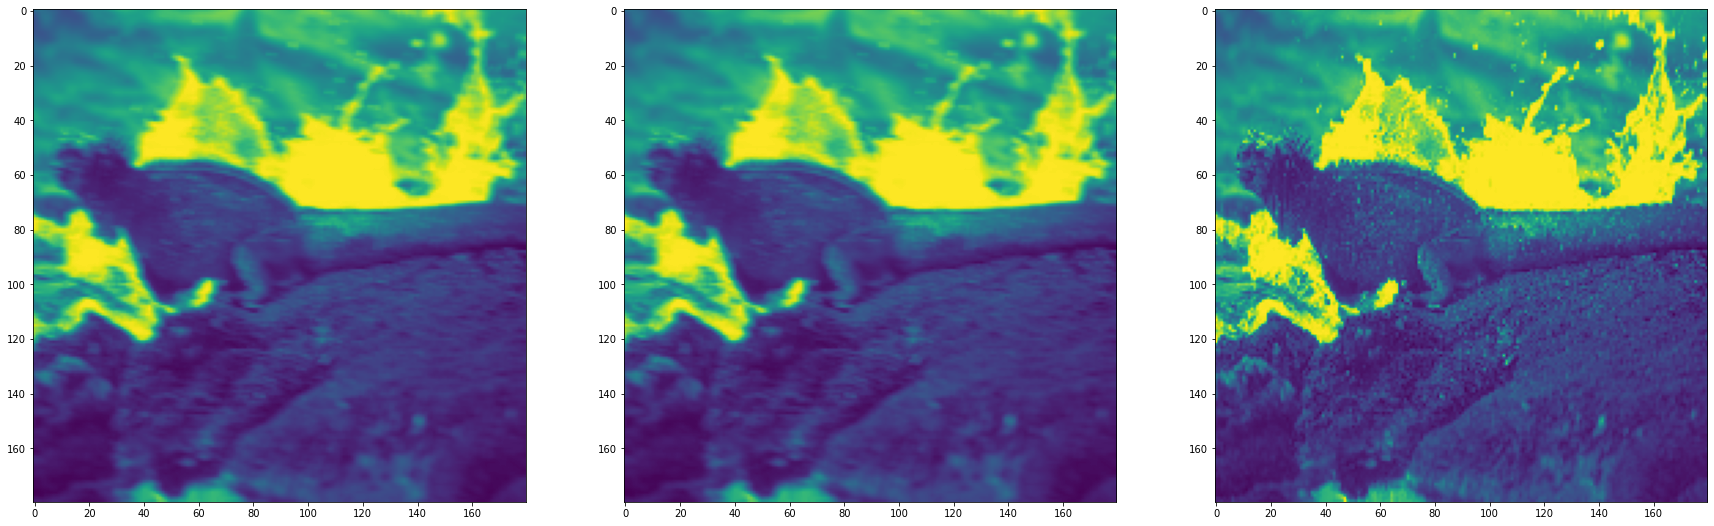

In [ ]:
plot_beside([y_pred[0, :, :, 2], x_test[0, :, :, 2], y_test[0, :, :, 2]], 3)

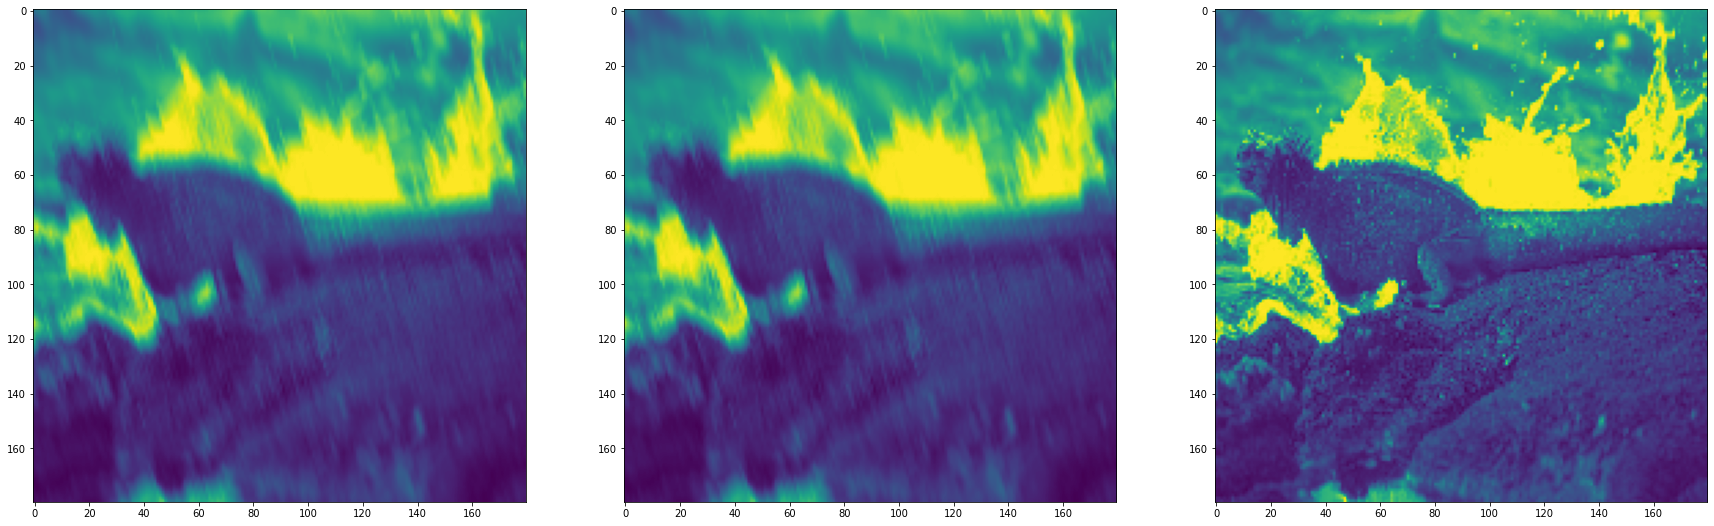

In [ ]:
plot_beside([y_pred[1, :, :, 2], x_test[1, :, :, 2], y_test[1, :, :, 2]], 3)

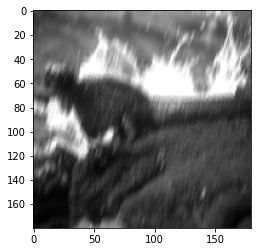

In [ ]:
plt.imshow(y_pred[2,:,:,0], cmap='gray')

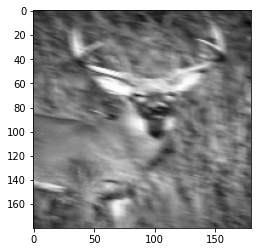

In [ ]:
plt.imshow(y_pred[3,:,:,0], cmap='gray')

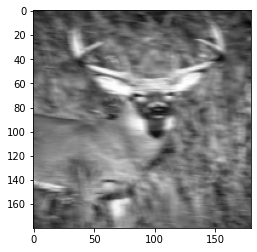

In [ ]:
plt.imshow(y_pred[4,:,:,0], cmap='gray')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()